In [4]:
import os
import base64
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from dotenv import load_dotenv
from tqdm import tqdm

from openai import OpenAI
from anthropic import Anthropic

load_dotenv()  # reads .env file

openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"), base_url='https://api.proxyapi.ru/openai/v1')
claude_client = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))


In [5]:
def classify_openai(image_path):
    with open(image_path, "rb") as f:
        img_b64 = base64.b64encode(f.read()).decode("utf-8")

    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Classify the car in the image as 'sports' or 'civilian'. Respond with one word only."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
                ]
            }
        ]
    )

    message_content = response.choices[0].message.content
    if isinstance(message_content, list):
        message_content = message_content[0].text

    return message_content.strip().lower()


def classify_claude(image_path):
    with open(image_path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")

    response = claude_client.messages.create(
        model="claude-haiku-4-5-20251001",
        max_tokens=10,
        messages=[
            {"role": "user",
             "content": [
                 {"type": "text", "text": "Classify this car as 'sports' or 'civilian'. Answer only one word."},
                 {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": b64}}
             ]
            }
        ]
    )
    return response.content[0].text.strip().lower()


In [6]:
def collect_dataset(root="data/images"):
    records = []
    for label in ["civilian", "sports"]:
        folder = os.path.join(root, label)
        for fn in sorted(os.listdir(folder)):
            if fn.lower().endswith(("jpg", "jpeg", "png")):
                records.append((os.path.join(folder, fn), label))
    return records

dataset = collect_dataset()
dataset[:5]


[('data/images\\civilian\\0001.jpg', 'civilian'),
 ('data/images\\civilian\\0002.jpeg', 'civilian'),
 ('data/images\\civilian\\0003.jpeg', 'civilian'),
 ('data/images\\civilian\\0004.jpg', 'civilian'),
 ('data/images\\civilian\\0005.jpg', 'civilian')]

In [7]:
openai_preds = []
claude_preds = []
true_labels = []


for path, label in tqdm(dataset):
    true_labels.append(label)
    openai_preds.append(classify_openai(path))
    claude_preds.append(classify_claude(path))

openai_preds = [p.replace(".", "") for p in openai_preds]
claude_preds = [p.replace(".", "") for p in claude_preds]       # модельки часто возвращают слово с точкой в конце

100%|██████████| 30/30 [04:20<00:00,  8.68s/it]


In [8]:
print("=== RESULTS ===")
print("\nOpenAI accuracy:", accuracy_score(true_labels, openai_preds))
print("Claude accuracy:", accuracy_score(true_labels, claude_preds))

print("\nOpenAI confusion matrix:\n", confusion_matrix(true_labels, openai_preds))
print("\nClaude confusion matrix:\n", confusion_matrix(true_labels, claude_preds))

print("\nOpenAI detailed report:\n", classification_report(true_labels, openai_preds))
print("\nClaude detailed report:\n", classification_report(true_labels, claude_preds))


=== RESULTS ===

OpenAI accuracy: 0.8333333333333334
Claude accuracy: 0.7666666666666667

OpenAI confusion matrix:
 [[11  4]
 [ 1 14]]

Claude confusion matrix:
 [[ 8  7]
 [ 0 15]]

OpenAI detailed report:
               precision    recall  f1-score   support

    civilian       0.92      0.73      0.81        15
      sports       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30


Claude detailed report:
               precision    recall  f1-score   support

    civilian       1.00      0.53      0.70        15
      sports       0.68      1.00      0.81        15

    accuracy                           0.77        30
   macro avg       0.84      0.77      0.75        30
weighted avg       0.84      0.77      0.75        30



In [9]:
print("\n=== Misclassified cases ===\n")

for (path, true), o, c in zip(dataset, openai_preds, claude_preds):
    if o != true or c != true:
        print(f"{path}: true={true}, openai={o}, claude={c}")



=== Misclassified cases ===

data/images\civilian\0002.jpeg: true=civilian, openai=civilian, claude=sports
data/images\civilian\0004.jpg: true=civilian, openai=sports, claude=sports
data/images\civilian\0006.jpg: true=civilian, openai=civilian, claude=sports
data/images\civilian\0008.jpg: true=civilian, openai=civilian, claude=sports
data/images\civilian\0010.jpg: true=civilian, openai=sports, claude=sports
data/images\civilian\0014.jpg: true=civilian, openai=sports, claude=sports
data/images\civilian\0015.jpg: true=civilian, openai=sports, claude=sports
data/images\sports\0014.jpg: true=sports, openai=civilian, claude=sports


✅ Результаты сохранены в results.xlsx


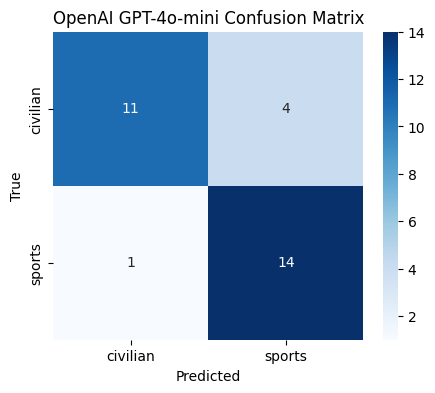

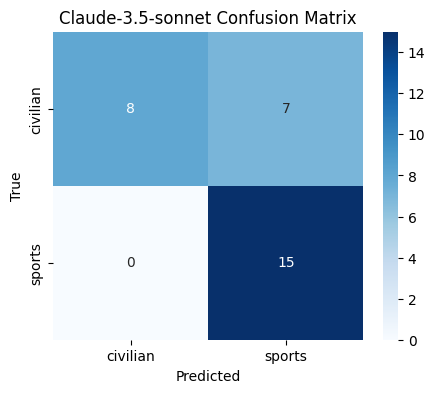

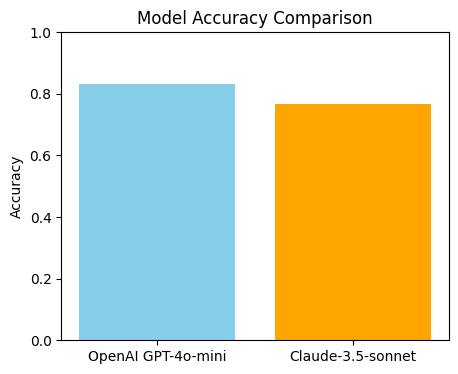

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Создаем DataFrame с результатами
df_results = pd.DataFrame({
    "image_path": [x[0] for x in dataset],
    "true_label": true_labels,
    "openai_pred": openai_preds,
    "claude_pred": claude_preds
})

# Сохраняем в Excel
df_results.to_excel("results.xlsx", index=False)
print("✅ Результаты сохранены в results.xlsx")

# Функция для отрисовки confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=["civilian", "sports"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["civilian", "sports"],
                yticklabels=["civilian", "sports"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Confusion Matrix OpenAI
plot_confusion_matrix(true_labels, openai_preds, title="OpenAI GPT-4o-mini Confusion Matrix")

# Confusion Matrix Claude
plot_confusion_matrix(true_labels, claude_preds, title="Claude-3.5-sonnet Confusion Matrix")

# Сравнение Accuracy
accuracy_openai = accuracy_score(true_labels, openai_preds)
accuracy_claude = accuracy_score(true_labels, claude_preds)

plt.figure(figsize=(5,4))
plt.bar(["OpenAI GPT-4o-mini","Claude-3.5-sonnet"], [accuracy_openai, accuracy_claude], color=["skyblue","orange"])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()
